In [146]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2


#train = pd.read_csv('digit-recognizer/train.csv')
#test = pd.read_csv('digit-recognizer/test.csv')
sudoku = pd.read_csv('sudoku_digits.csv')

In [147]:
sudoku

,Unnamed: 0,label,1,2,3,4,5,6,7,8,...,775,776,777,778,779,780,781,782,783,784
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,22,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
104,23,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
105,24,9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
106,25,9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [148]:
#cols = train.columns
sudoku.drop('Unnamed: 0', axis=1, inplace=True)
#sudoku.columns = cols
#new = pd.concat([train, sudoku], axis=0, ignore_index=True)
new = sudoku

In [149]:
new

,label,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
104,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
105,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
106,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [150]:
digit_features = new.copy()
digit_label = digit_features.pop('label')

In [151]:
digit_features.head(5)

,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [152]:
digit_features = digit_features.to_numpy().reshape(-1,28,28)
digit_label = digit_label.to_numpy()
digit_features = tf.expand_dims(digit_features, axis=-1)
digit_label = tf.one_hot(digit_label, depth = 10, on_value=1, axis=-1)

tf.Tensor([0 0 0 1 0 0 0 0 0 0], shape=(10,), dtype=int32)


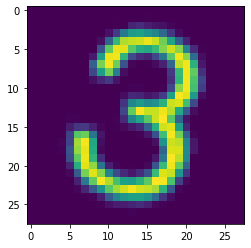

In [153]:
i = 8
plt.imshow(digit_features[i])
print(digit_label[i])

In [157]:
new.shape

(108, 785)

In [158]:
size = new.shape[0]//10

x_train, x_val = tf.split(digit_features, [90, 18])
y_train, y_val = tf.split(digit_label, [90, 18])

In [159]:
x_train.shape

TensorShape([90, 28, 28, 1])

In [189]:
model = tf.keras.Sequential([
    layers.Conv2D(filters=32, kernel_size=5, activation='relu', padding='valid',
                  input_shape=(28, 28, 1)),
    layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    
    layers.Dropout(rate=0.3),
    layers.Conv2D(filters=64, kernel_size=5, activation='relu', padding='valid'),
    layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
    
    layers.Flatten(),
    layers.Dense(10, activation='softmax'),
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

early_stopping = callbacks.EarlyStopping(patience=5, min_delta=0.001, restore_best_weights=True)


In [190]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=10, epochs=50, callbacks=early_stopping, verbose=2)

Epoch 1/50
9/9 - 1s - loss: 44.2859 - categorical_accuracy: 0.1667 - val_loss: 6.0762 - val_categorical_accuracy: 0.3333
Epoch 2/50
9/9 - 0s - loss: 10.9430 - categorical_accuracy: 0.3778 - val_loss: 0.8899 - val_categorical_accuracy: 0.6667
Epoch 3/50
9/9 - 0s - loss: 2.8126 - categorical_accuracy: 0.5889 - val_loss: 1.1787 - val_categorical_accuracy: 0.5556
Epoch 4/50
9/9 - 0s - loss: 1.7467 - categorical_accuracy: 0.7333 - val_loss: 0.1594 - val_categorical_accuracy: 0.8889
Epoch 5/50
9/9 - 0s - loss: 0.8492 - categorical_accuracy: 0.8889 - val_loss: 0.8727 - val_categorical_accuracy: 0.7778
Epoch 6/50
9/9 - 0s - loss: 0.9681 - categorical_accuracy: 0.8556 - val_loss: 0.3768 - val_categorical_accuracy: 0.7778
Epoch 7/50
9/9 - 0s - loss: 0.2100 - categorical_accuracy: 0.9111 - val_loss: 0.5516 - val_categorical_accuracy: 0.8333
Epoch 8/50
9/9 - 0s - loss: 0.0470 - categorical_accuracy: 0.9778 - val_loss: 0.1250 - val_categorical_accuracy: 0.9444
Epoch 9/50
9/9 - 0s - loss: 0.0314 - c

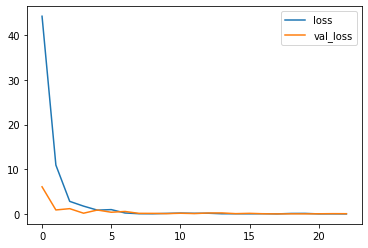

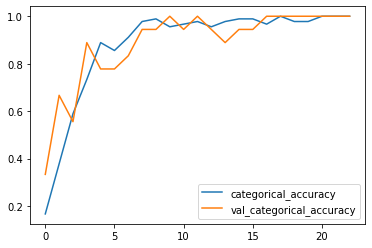

In [191]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot();

In [102]:
def model_predict(num):
    num = str(num)
    image = cv2.imread('{num}.jpg'.format(num=num), cv2.IMREAD_GRAYSCALE)
    image = 255 - image
    image = tf.expand_dims(image, axis=-1)
    image = tf.expand_dims(image, axis=0)
    number = model(image)
    
    return np.argmax(number, axis=1)[0]

In [116]:
model_predict(6)

6

In [192]:
model.save('model')

INFO:tensorflow:Assets written to: model\assets
